In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as spy
import h5py
from scipy.ndimage import median_filter
from scipy.ndimage import uniform_filter1d
from scipy import interpolate
from time import time
from mpl_toolkits.axes_grid1 import make_axes_locatable

import tomopy
import dxchange
import logging
logging.basicConfig(level=logging.INFO)

import sscRaft
#import sscRaftApps
import sscRings

DEVICE = 'cpu'
CPUS = 64

astropy module not found
olefile module not found
/mnt/bgfs/projects/tomo_nano/envs/tomo/lib/python3.9/site-packages/dxchange/__init__.py:63: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [2]:
def print_fig(x, names = None, limits = None):
    """
        x (list of arrays): [x1, x2, x3, ...]
        names (list of str): ['Title 1', 'Title 2', 'Title 2', ...]
        limits (list of list): [ [min_1,max_1], [min_2,max_2], [min_3,max_3], ... ]
    """
    n = len(x)
    
    fig, ax_ = plt.subplots(1,n, figsize = (20*n,16*n))
    if(n == 1):
        ax_ = [ax_]
        
    for i,ax in enumerate(ax_):
        if limits is not None and limits[i] is not None:
            im = ax.imshow(x[i], vmin = limits[i][0], vmax = limits[i][1])
        else:
            im = ax.imshow(x[i])
        divider = make_axes_locatable(ax)
        cax = divider.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(im, cax=cax, orientation='vertical')
        ax.set_xlim(0,x[i].shape[1])
        ax.set_ylim(x[i].shape[0],0)
        
        if names != None:
            ax.set_title(names[i])
    
    plt.show()

def read_and_normalize_tomogram(path, sample, slices = [0,2048], eixo_rot = None):

    with h5py.File(path+sample, 'r') as f:
        flat      = np.mean(np.mean(f['scan/detector/flats'][:, :, slices[0]:slices[1], :].astype(np.float32()),axis=0),axis=0)
        dark      = np.mean(np.mean(f['scan/detector/darks'][:, :, slices[0]:slices[1], :].astype(np.float32()),axis=0),axis=0)
        tomogram  = f['scan/detector/data'][:,slices[0]:slices[1],:].astype(np.float32())

    tomogram = -np.log((tomogram - dark[np.newaxis,:,:])/(flat[np.newaxis, :, :] - dark[np.newaxis, :, :]))
    tomogram[np.isnan(tomogram)] = 0.0
    tomogram[np.isinf(tomogram)] = 0.0


    if(eixo_rot == None):
        # 180
        deviation = sscRaft.Centersino(tomogram[0], tomogram[tomogram.shape[0]-1], 
                    np.ones((tomogram.shape[1], tomogram.shape[2])), np.zeros((tomogram.shape[1], tomogram.shape[2])))
        #360
        # deviation = sscRaft.Centersino(tomogram[0], tomogram[tomogram.shape[0]//2], 
        #             np.ones((tomogram.shape[1], tomogram.shape[2])), np.zeros((tomogram.shape[1], tomogram.shape[2])))
        print(deviation)
    else:
        deviation = eixo_rot
        print(deviation)
        

    if(deviation < 0):
        tomogram = pad_volume(tomogram, 0, -2*deviation)
    if(deviation > 0):
        tomogram = pad_volume(tomogram, 2*deviation, 0)

    tomogram = np.swapaxes(tomogram,0,1)

    return tomogram

def pad_volume(volume, k_left, k_right):
    """
    Pads a 3D volume along the third axis with the border values.

    Parameters:
        volume (numpy.ndarray): 3D array of shape (x, y, N).
        k (int): Padding size.

    Returns:
        numpy.ndarray: Padded 3D volume of shape (x, y, N + 2k).
    """
    if (k_left < 0) or (k_right < 0):
        raise ValueError("Padding size k must be non-negative")
    if volume.ndim != 3:
        raise ValueError("Input volume must be a 3D array")
    
    # Extract border values along the third axis
    left_pad = np.tile(volume[:, :, 0:1], (1, 1, k_left))  # Left padding
    right_pad = np.tile(volume[:, :, -1:], (1, 1, k_right))  # Right padding
    
    # Concatenate paddings with the original volume
    padded_volume = np.concatenate([left_pad, volume, right_pad], axis=2)
    
    return padded_volume

def save_hdf5(filepath, recon):
    # Ensure recon is in float32 format without creating an unnecessary copy
    if recon.dtype != np.float32:
        recon = recon.astype(np.float32, copy=False)  # Use copy=False to avoid duplication
    
    # Use a context manager to handle the file
    with h5py.File(filepath, 'w') as file:
        # Use chunking and compression for large datasets
        file.create_dataset("data", data=recon)

In [3]:
path = '/mnt/bgfs/projects/tomo_nano/data/'
sample = 'tomo_A20A_eps_1263nm_000.hdf5'

In [4]:
with h5py.File(path+sample, 'r') as f:

    z1    = f['snapshot/after/beamline-state/position/nano-station/z1/value'][()] * 1e-3
    z2    = f['snapshot/after/beamline-state/position/nano-station/z2/value'][()] * 1e-3
    z1z2  = f['snapshot/after/beamline-state/position/nano-station/z1+z2/value'][()] * 1e-3
    pixel = f['snapshot/after/beamline-state/position/detector/pixel-size-x/value'][()] * 1e-3

magn      = (z1+z2) / z1
pixel_obj = pixel / magn
z2_eff    = z2 / magn
energy    = 22e3

In [5]:
tomogram = read_and_normalize_tomogram(path, sample, [0,1017], eixo_rot = 13)
slices, angles, length = tomogram.shape

theta = np.linspace(0,np.pi,angles)

13


In [6]:
tomogram = np.swapaxes(tomogram,0,1)

In [7]:
rot_center = tomopy.find_center(tomogram, theta, init=None, ind=512, tol=0.5,mask=True,ratio=0.65)

INFO:tomopy.recon.algorithm:Reconstructing 1 slice groups with 1 master threads...
INFO:tomopy.recon.rotation:Trying rotation center: [1037.]
INFO:tomopy.recon.algorithm:Reconstructing 1 slice groups with 1 master threads...
INFO:tomopy.recon.rotation:Function value = 1.429248
INFO:tomopy.recon.rotation:Trying rotation center: [1088.85]
INFO:tomopy.recon.algorithm:Reconstructing 1 slice groups with 1 master threads...
INFO:tomopy.recon.rotation:Function value = 1.427603
INFO:tomopy.recon.rotation:Trying rotation center: [1140.7]
INFO:tomopy.recon.algorithm:Reconstructing 1 slice groups with 1 master threads...
INFO:tomopy.recon.rotation:Function value = 1.465284
INFO:tomopy.recon.rotation:Trying rotation center: [1062.925]
INFO:tomopy.recon.algorithm:Reconstructing 1 slice groups with 1 master threads...
INFO:tomopy.recon.rotation:Function value = 1.394904
INFO:tomopy.recon.rotation:Trying rotation center: [1037.]
INFO:tomopy.recon.algorithm:Reconstructing 1 slice groups with 1 master 

In [8]:
tomogram = tomopy.median_filter(tomogram, axis=0)

In [9]:
tomogram = tomopy.prep.stripe.remove_stripe_ti(tomogram,alpha=1.5,nblock=4)

In [10]:
tomogram_phase = tomopy.prep.phase.retrieve_phase(tomogram, pixel_size=pixel_obj*100, dist=z2_eff*100, energy=energy/1e3,
                                                  alpha=1e-5,
                                                  ncore=CPUS, pad=True)

In [11]:
recon_phase = tomopy.recon(tomogram_phase, theta, center=rot_center, algorithm='gridrec', sinogram_order=False, ncore=CPUS, num_gridx=1330, num_gridy=1330, filter_name='shepplogan')

INFO:tomopy.recon.algorithm:Reconstructing 64 slice groups with 64 master threads...


In [12]:
recon_phase = tomopy.circ_mask(recon_phase, axis=0, ratio=1.0)

In [13]:
recon_phase = tomopy.misc.corr.remove_ring(recon_phase, rwidth=25, int_mode = "REFLECT", ncore=CPUS)

In [15]:
dxchange.write_tiff_stack(fname='data/recon_phase/recon_data', data=recon_phase,
                              dtype='int8', overwrite=True)

In [16]:
recon_phase_int = ((recon_phase - recon_phase.min()) / (recon_phase.max() - recon_phase.min()) * 255.).astype(int)

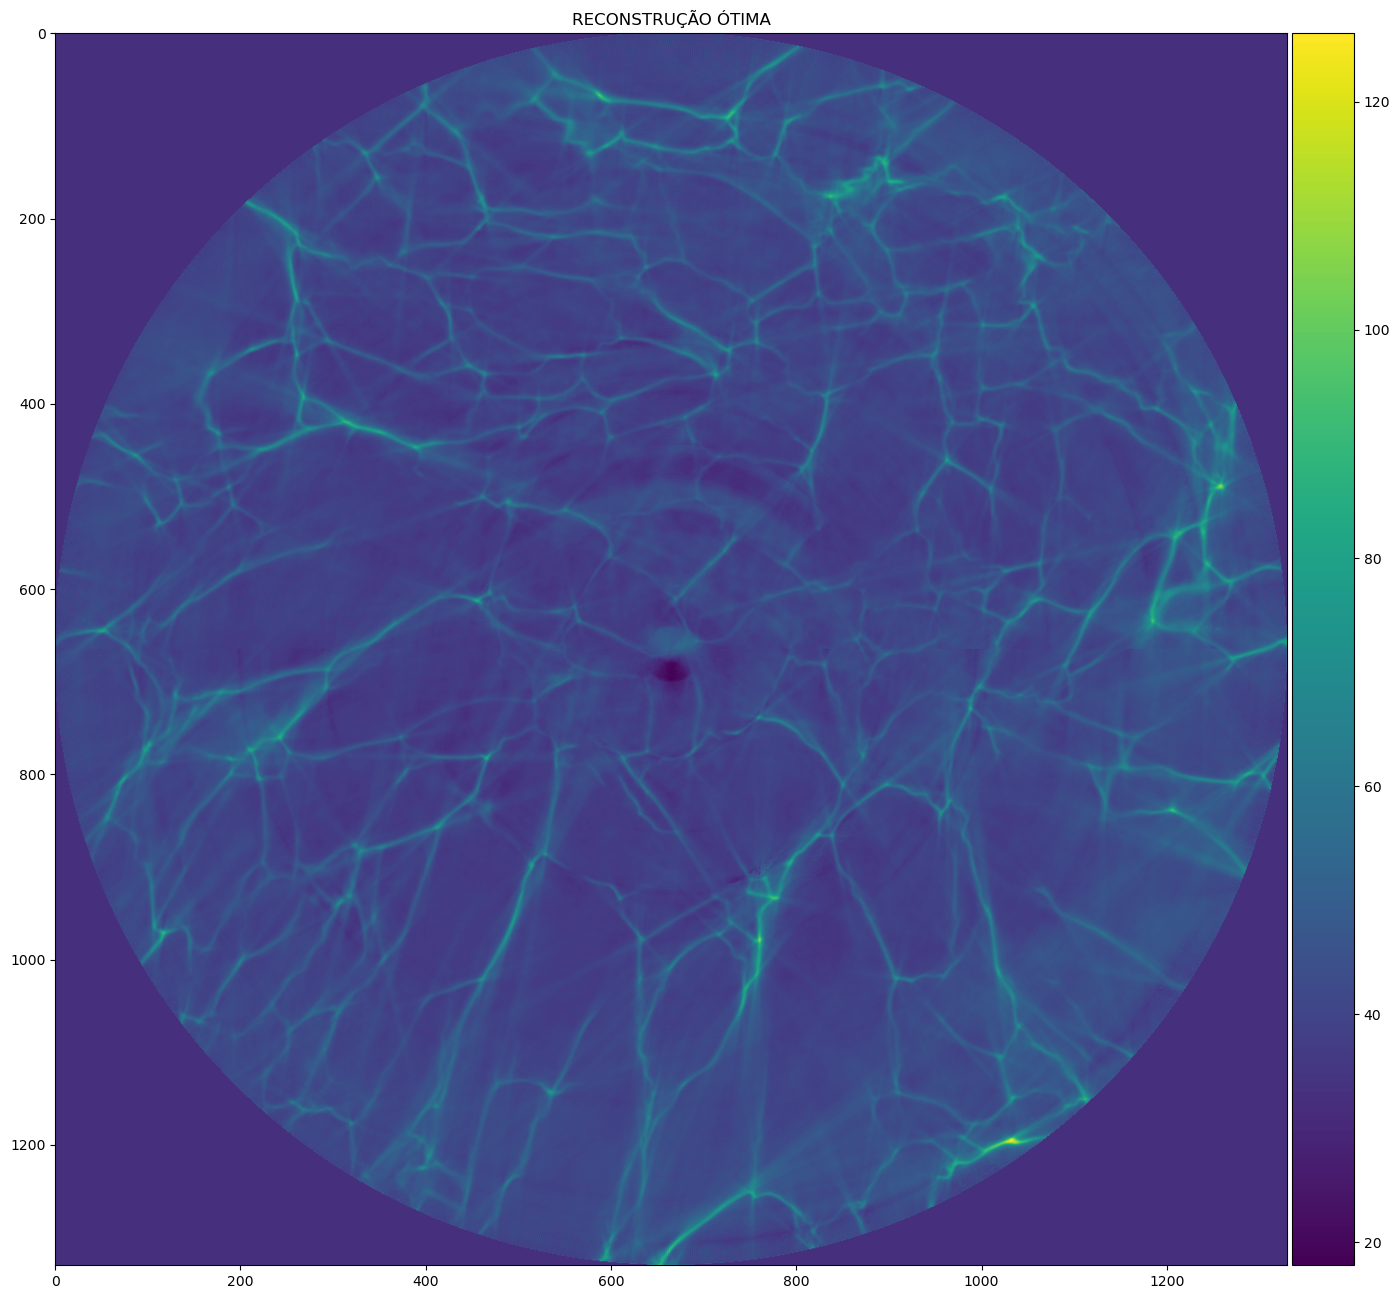

In [17]:
print_fig([recon_phase_int[512]], names = ["RECONSTRUÇÃO ÓTIMA"])

In [18]:
dxchange.write_tiff_stack(fname='data/recon_phase_int/recon_data', data=recon_phase_int,
                              dtype='int8', overwrite=True)